In [410]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d

from sivqed.models.siv import SiV
from sivqed.models.cavity import Cavity, CavitySiV

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

# No perturbations

## Empty cavity spectrum

In [411]:
freqs = np.linspace(-500, 500, 1000)

c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : 0, "g_up" : 5.39, "gamma_up" : 0.05})
cavity_spectrum = c.reflectance(freqs, -1)
cavity_min = min(cavity_spectrum)

print(f"Cavity min = {cavity_min:.3}")
print(f"Cooperativity = {c.qubit_params['g_up']**2 / (c.cavity_params['k_tot'] * c.qubit_params['gamma_up']):.3}")

Cavity min = 0.104
Cooperativity = 8.94


## Obtain min/max values for SiV spectrum at various detunings

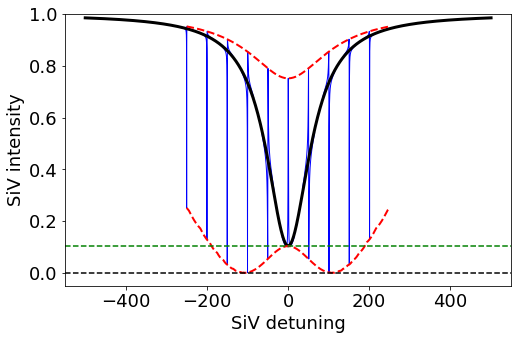

In [412]:
siv_min = []
siv_max = []
detuning_freqs = np.linspace(-250, 250, 1000)

for idx, detuning in enumerate(detuning_freqs):
    # Set a particular value of detuning
    c.set_qubit_params({"w_up" : detuning})
    
    # Only plot the spectrum around the SiV resonance
    freqs_filtered = np.linspace(detuning - 15, detuning + 15, 2000)
    siv_spectrum_filtered = c.reflectance(freqs_filtered, 1)
    # Only plot a few spectra
    if idx % 100 == 0:
        plt.plot(freqs_filtered, siv_spectrum_filtered, 'b', lw=1, label="up")
    
    siv_min.append(min(siv_spectrum_filtered))
    siv_max.append(max(siv_spectrum_filtered))
    
siv_min = np.array(siv_min)
siv_max = np.array(siv_max)

# Plot the empty cavity spectrum
plt.plot(freqs, cavity_spectrum, 'k', lw=3, label="empty")
# Plot the min and max SiV spectrum envelope
plt.plot(detuning_freqs, siv_min, 'r--', lw=2)
plt.plot(detuning_freqs, siv_max, 'r--', lw=2)

plt.xlabel("SiV detuning")
plt.ylabel("SiV intensity")
plt.ylim(-0.05, 1.0)
plt.axhline(0.0, c='k', ls='--', lw=1.5)
plt.axhline(cavity_min, c='g', ls='--', lw=1.5)

siv_contrast = [max_val / min_val for (min_val, max_val) in zip(siv_min, siv_max)]

### Plotting SiV peak contrast & SiV dip ratio (relative to cavity minimum)

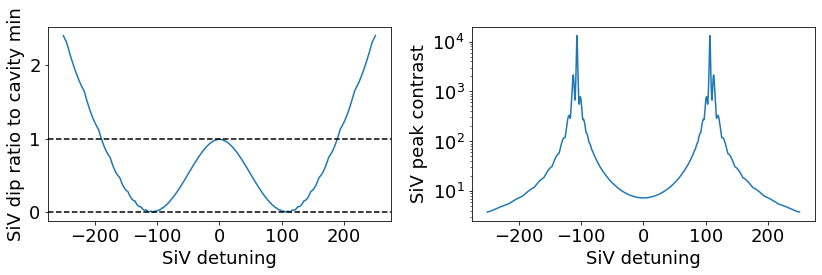

In [413]:
fig, ax = plt.subplots(1, 2, figsize=[12, 4])

ax[0].plot(detuning_freqs, siv_min / cavity_min)
ax[0].axhline(0.0, c='k', ls='--', lw=1.5)
ax[0].axhline(1.0, c='k', ls='--', lw=1.5)
ax[0].set_xlabel("SiV detuning")
ax[0].set_ylabel("SiV dip ratio to cavity min")

ax[1].semilogy(detuning_freqs, siv_contrast)
ax[1].set_xlabel("SiV detuning")
ax[1].set_ylabel("SiV peak contrast")

fig.tight_layout()

# -----------------------------
# Spectral Diffusion

## Testing convolution vs weighted translation vs changing detuning
There are 3 options for simulating spectral diffusion:
1. Convolve the original SiV spectrum with a Gaussian
2. Translate the SiV spectrum by some amount and weigh by a Gaussian (should be same as 1)
3. Change the detuning by some amount and weigh by a Gaussian (should be same as 2 in limit of small diffusion, i.e. when changing detuning only translates and does not change peak shape much)

We will test methods 1 and 3 to check if they are the same.

### Manual convolution

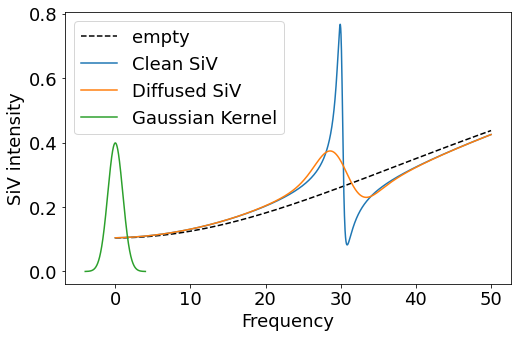

In [414]:
# Freq for plotting range
freqs = np.linspace(0, 50, 2500)

# SiV parameters
# Fixed SiV detuning
detuning = 30 
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})

# Save the empty cavity and the clean SiV
cavity_spectrum = c.reflectance(freqs, -1)
siv_spectrum = c.reflectance(freqs, 1)

# Diffusion stdev for the Gaussian
diffusion = 2.0

def manual_conv(cavity, detuning, freqs, diffusion):
    # Perform the manual convolution by summing around plus-minus 4 sigma
    diffusion_freqs = np.linspace(-4*diffusion, 4*diffusion, 1000)
    norm_pdf = norm(loc=0, scale=diffusion).pdf

    # Perform the diffusion by shifting the detuning by a given displacement
    # then weigh that spectrum by the Gaussian pdf
    diffused_siv_spectrum = np.zeros(freqs.shape)
    for diffusion_freq in diffusion_freqs:
        cavity.set_qubit_params({"w_up" : detuning + diffusion_freq})
        diffused_siv_spectrum += cavity.reflectance(freqs, 1) * norm_pdf(diffusion_freq)
    # Normalize by the iteration step size 
    diffused_siv_spectrum *= (diffusion_freqs[1] - diffusion_freqs[0])
    
    return diffused_siv_spectrum
    
diffused_siv_spectrum = manual_conv(c, detuning, freqs, diffusion)

# Plot the empty cavity spectrum
plt.plot(freqs, cavity_spectrum, 'k--', label="empty")
# Plot the clean and diffused SiV spectrum
plt.plot(freqs, siv_spectrum, label="Clean SiV")
plt.plot(freqs, diffused_siv_spectrum, label="Diffused SiV")
# Plot the convolution kernel
plt.plot(diffusion_freqs, norm_pdf(diffusion_freqs), label="Gaussian Kernel")

plt.xlabel("Frequency")
plt.ylabel("SiV intensity")
plt.legend()

### Automatic convolution

Text(0, 0.5, 'Gaussian Kernel')

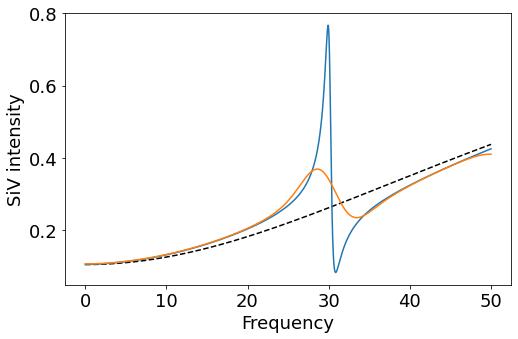

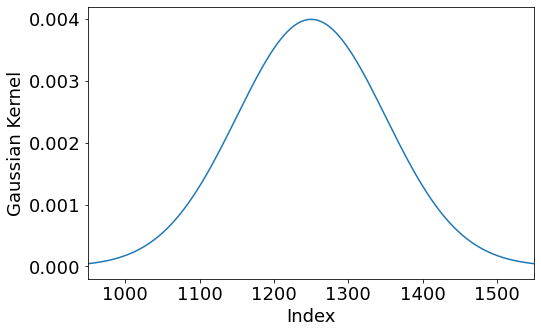

In [423]:
# Freq for plotting range
freqs = np.linspace(0, 50, 2500)

# SiV parameters
# Fixed SiV detuning
detuning = 30 
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})

# Save the empty cavity and the clean SiV
cavity_spectrum = c.reflectance(freqs, -1)
siv_spectrum = c.reflectance(freqs, 1)

# Diffusion using Gaussian filter
# Normalization to convert from freq value to index value
diffusion = 2.0 / (freqs[1] - freqs[0])

# Compute the diffused spectrum
diffused_siv_spectrum_auto = gaussian_filter1d(siv_spectrum, diffusion)

# Plot the empty cavity spectrum
plt.plot(freqs, cavity_spectrum, 'k--', label="empty")
# Plot the clean and diffused SiV spectrum
plt.plot(freqs, siv_spectrum, label="Clean SiV")
plt.plot(freqs, diffused_siv_spectrum_auto, label="Diffused SiV")
plt.xlabel("Frequency")
plt.ylabel("SiV intensity")

# Plot the Gaussian filter by applying it on a spike function
spike = np.zeros(siv_spectrum.shape)
spike[spike.size//2] = 1
# Center around the spike and plot 3 stdevs
plt.figure()
plt.plot(gaussian_filter1d(spike, diffusion))
plt.xlim(spike.size//2 - 3*diffusion, spike.size//2 + 3*diffusion)
plt.xlabel("Index")
plt.ylabel("Gaussian Kernel")

### Comparison of 2 methods

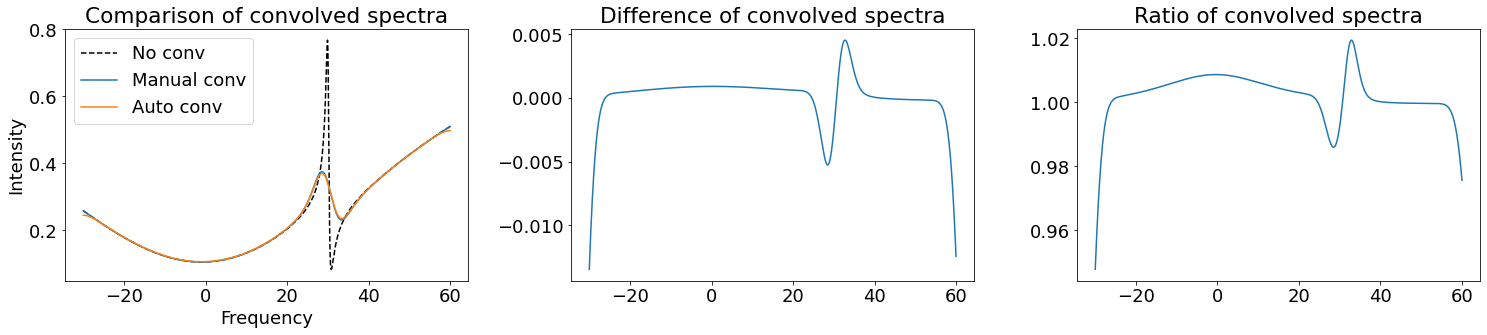

In [399]:
freqs = np.linspace(-30, 60, 2500)
detuning = 30
diffusion = 2.0
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})
siv_spectrum = c.reflectance(freqs, 1)

diffused_siv_spectrum = manual_conv(c, detuning, freqs, diffusion)
diffused_siv_spectrum_auto = gaussian_filter1d(siv_spectrum, diffusion / (freqs[1] - freqs[0]))

fig, ax = plt.subplots(ncols=3, figsize=(21, 5))

ax[0].plot(freqs, siv_spectrum, 'k--', label="No conv")
ax[0].plot(freqs, diffused_siv_spectrum, label="Manual conv")
ax[0].plot(freqs, diffused_siv_spectrum_auto, label="Auto conv")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Intensity")
ax[0].set_title("Comparison of convolved spectra")
ax[0].legend()

ax[1].plot(freqs, diffused_siv_spectrum_auto - diffused_siv_spectrum)
ax[1].set_title("Difference of convolved spectra")

ax[2].plot(freqs, diffused_siv_spectrum_auto / diffused_siv_spectrum)
ax[2].set_title("Ratio of convolved spectra")
fig.tight_layout()

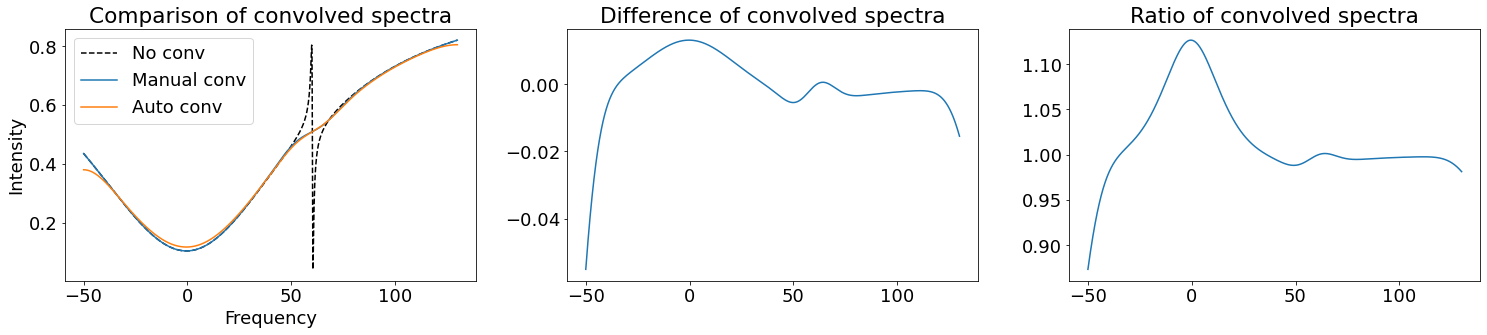

In [398]:
freqs = np.linspace(-50, 130, 2500)
detuning = 60
diffusion = 8.0
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})
siv_spectrum = c.reflectance(freqs, 1)

diffused_siv_spectrum = manual_conv(c, detuning, freqs, diffusion)
diffused_siv_spectrum_auto = gaussian_filter1d(siv_spectrum, diffusion / (freqs[1] - freqs[0]))

fig, ax = plt.subplots(ncols=3, figsize=(21, 5))

ax[0].plot(freqs, siv_spectrum, 'k--', label="No conv")
ax[0].plot(freqs, diffused_siv_spectrum, label="Manual conv")
ax[0].plot(freqs, diffused_siv_spectrum_auto, label="Auto conv")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Intensity")
ax[0].set_title("Comparison of convolved spectra")
ax[0].legend()

ax[1].plot(freqs, diffused_siv_spectrum_auto - diffused_siv_spectrum)
ax[1].set_title("Difference of convolved spectra")

ax[2].plot(freqs, diffused_siv_spectrum_auto / diffused_siv_spectrum)
ax[2].set_title("Ratio of convolved spectra")
fig.tight_layout()

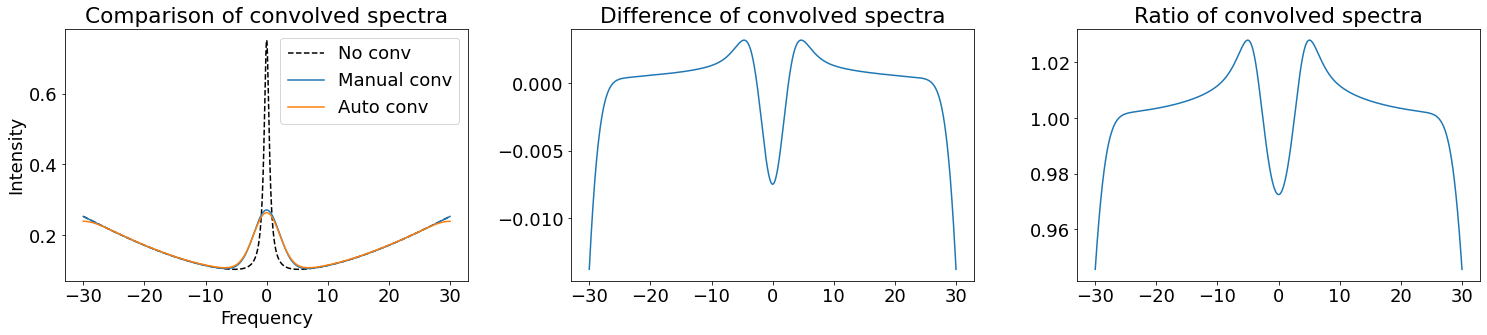

In [406]:
freqs = np.linspace(-30, 30, 5000)
detuning = 0
diffusion = 2.0
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})
siv_spectrum = c.reflectance(freqs, 1)

diffused_siv_spectrum = manual_conv(c, detuning, freqs, diffusion)
diffused_siv_spectrum_auto = gaussian_filter1d(siv_spectrum, diffusion / (freqs[1] - freqs[0]))

fig, ax = plt.subplots(ncols=3, figsize=(21, 5))

ax[0].plot(freqs, siv_spectrum, 'k--', label="No conv")
ax[0].plot(freqs, diffused_siv_spectrum, label="Manual conv")
ax[0].plot(freqs, diffused_siv_spectrum_auto, label="Auto conv")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Intensity")
ax[0].set_title("Comparison of convolved spectra")
ax[0].legend()

ax[1].plot(freqs, diffused_siv_spectrum_auto - diffused_siv_spectrum)
ax[1].set_title("Difference of convolved spectra")

ax[2].plot(freqs, diffused_siv_spectrum_auto / diffused_siv_spectrum)
ax[2].set_title("Ratio of convolved spectra")
fig.tight_layout()

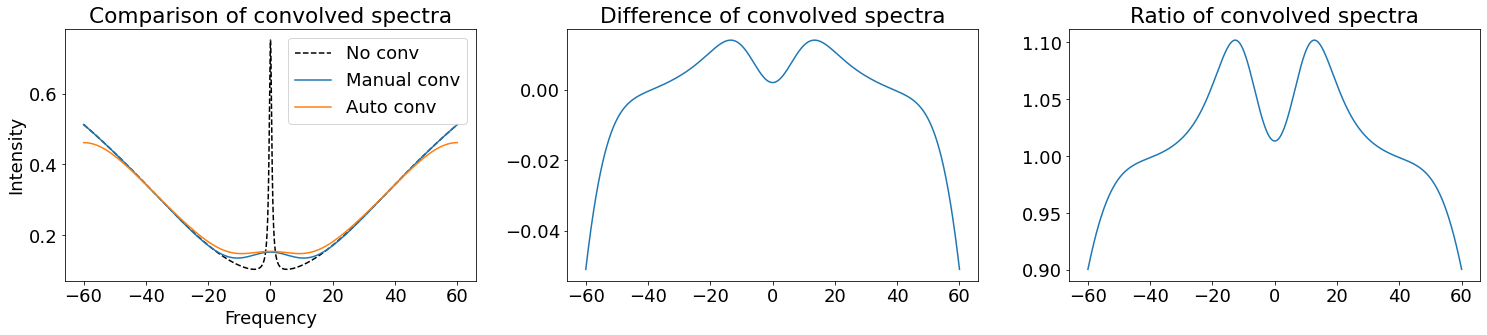

In [409]:
freqs = np.linspace(-60, 60, 5000)
detuning = 0
diffusion = 8.0
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})
siv_spectrum = c.reflectance(freqs, 1)

diffused_siv_spectrum = manual_conv(c, detuning, freqs, diffusion)
diffused_siv_spectrum_auto = gaussian_filter1d(siv_spectrum, diffusion / (freqs[1] - freqs[0]))

fig, ax = plt.subplots(ncols=3, figsize=(21, 5))

ax[0].plot(freqs, siv_spectrum, 'k--', label="No conv")
ax[0].plot(freqs, diffused_siv_spectrum, label="Manual conv")
ax[0].plot(freqs, diffused_siv_spectrum_auto, label="Auto conv")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Intensity")
ax[0].set_title("Comparison of convolved spectra")
ax[0].legend()

ax[1].plot(freqs, diffused_siv_spectrum_auto - diffused_siv_spectrum)
ax[1].set_title("Difference of convolved spectra")

ax[2].plot(freqs, diffused_siv_spectrum_auto / diffused_siv_spectrum)
ax[2].set_title("Ratio of convolved spectra")
fig.tight_layout()

# Testing method speeds

Overall the 2 methods appear to be identical aside from some minor differences. We will now test the speeds.

In [ ]:
freqs = np.linspace(0, 50, 2500)
detuning = 30
diffusion = 2.0
c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : detuning, "g_up" : 5.39, "gamma_up" : 0.05})
siv_spectrum = c.reflectance(freqs, 1)

In [353]:
%timeit manual_conv(c, detuning, freqs, diffusion)

161 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [352]:
%timeit gaussian_filter1d(siv_spectrum, diffusion / (freqs[1] - freqs[0]))

1.1 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


There might be some code from the manual code that we can optimize but the automatic code is probably easier and also faster. 